生成数据集

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline

samples, labels = make_blobs(n_samples=500,  # 500个样本
                             n_features=2,  # 每个样本2个特征
                             centers=5,  # 5个中心
                             random_state=42  # 随机数种子
                             )
# 保存数据集
sio.savemat('mydataset.mat', mdict={'samples': samples, 'labels': labels})


Text(0.5, 1.0, 'Generated dataset (without labels)')

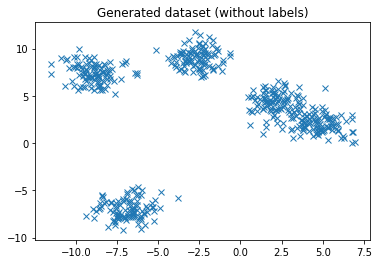

In [2]:
# 读取dataset
dict = sio.loadmat('mydataset')
samples = dict['samples']
labels_ = dict['labels']
labels_ = labels_.reshape(-1)  # 转换矩阵形状
# num, dim = samples.shape  #数据个数，维数
# 数据显示
plt.plot(samples[:, 0], samples[:, 1], 'x')
plt.title("Generated dataset (without labels)")


Text(0.5, 1.0, 'Generated dataset (with labels)')

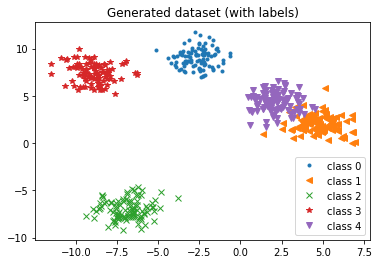

In [3]:
styles = ['.', '<', 'x', '*', 'v', '^']
for k in range(5):
    plt.plot(samples[labels_ == k, 0], samples[labels_ == k, 1], styles[k])

plt.legend([f'class {k}' for k in range(5)])
plt.title("Generated dataset (with labels)")


k-means

In [4]:
def kmeans(samples: np.ndarray, K: int, max_iter=20):  # K类
    """
    Parameters:
        samples - 样本集
        K - 聚类个数
        max_iter - 迭代最大次数
    Returns:
        各类的中心点集, 每个样本对应的标签集
    """
    N, D = samples.shape
    # centers = np.random.rand(K, D)

    # 随机从数据集中取样作为中心点
    index = np.random.choice(N, K, replace=False)
    centers = samples[index]
    labels = -np.ones(N)
    for _ in range(max_iter):
        changed = False
        # 更新类别
        for j in range(N):
            # 欧氏距离
            dist = np.sum((samples[j] - centers)**2, 1)
            # 曼哈顿距离
            # dist = np.sum(np.abs(samples[j] - centers), 1)
            if labels[j] != np.argmin(dist):
                # 根据距离最近的均值向量确定xj的簇标记
                labels[j] = np.argmin(dist)
                changed = True

        if not changed:  # 当前均值向量均未更新
            return centers, labels
        # 更新中心
        for k in range(K):
            centers[k] = np.mean(samples[labels == k], 0)
    return centers, labels


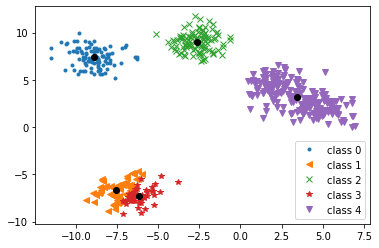

In [5]:
K = 5
centers, labels = kmeans(samples, K)
styles = ['.', '<', 'x', '*', 'v', '^']
for k in range(K):
    plt.plot(samples[labels == k, 0], samples[labels == k, 1], styles[k])

plt.legend([f'class {k}' for k in range(K)])
plt.plot(centers[:, 0], centers[:, 1], 'ko')  # 画中心点


层次聚类 AGNES

In [6]:
# 定义聚类簇距离度量函数
def d_min(Ci: np.ndarray, Cj: np.ndarray):
    min_distance = np.Inf
    for xi in Ci:
        for xj in Cj:
            min_distance = min(min_distance, np.sum((xi-xj)**2))
    return np.sqrt(min_distance)


def d_max(Ci: np.ndarray, Cj: np.ndarray):
    max_distance = -np.Inf
    for xi in Ci:
        for xj in Cj:
            max_distance = max(max_distance, np.sum((xi-xj)**2))
    return np.sqrt(max_distance)


def d_avg(Ci: np.ndarray, Cj: np.ndarray):
    cnt = 0
    avg_distance = 0
    for xi in Ci:
        for xj in Cj:
            avg_distance += np.sqrt(np.sum((xi-xj)**2))
            cnt += 1
    return avg_distance/cnt


In [7]:
def AGNES(samples: np.ndarray, K: int, dist_fuction = d_avg):  # K类
    """
    Parameters:
        samples - 样本集
        K - 聚类个数
        dist_function - 聚类簇距离度量函数
    Returns:
        各簇划分
    """
    N, D = samples.shape
    # 初始化单样本聚类簇
    Clusters = [sample.reshape(1, -1) for sample in samples]
    M = np.zeros((N, N))  # 距离矩阵
    # 初始化聚类簇距离矩阵
    for i in range(N):
        M[i][i] = np.Inf
        for j in range(i+1, N):
            M[i][j] = dist_fuction(Clusters[i], Clusters[j])
            M[j][i] = M[i][j]
    # 设置当前聚类簇个数
    cluster_num = N
    while cluster_num > K:
        # 找出距离最近的两个聚类簇
        i_, j_ = np.unravel_index(M.argmin(), M.shape)
        # 合并
        Clusters[i_] = np.concatenate((Clusters[i_], Clusters[j_]))
        del Clusters[j_]
        # 删除距离矩阵的j_行与j_列
        M = np.delete(M, j_, axis=1)
        M = np.delete(M, j_, axis=0)
        cluster_num -= 1

        for j in range(cluster_num):
            if j != i_:
                M[i_][j] = dist_fuction(Clusters[i_], Clusters[j])
                M[j][i_] = M[i_][j]

    return Clusters


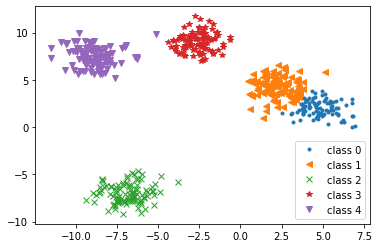

In [8]:
K = 5
clusters = AGNES(samples, K, d_avg)
styles = ['.', '<', 'x', '*', 'v', '^']

for k in range(K):
    plt.plot(clusters[k][:, 0], clusters[k][:, 1], styles[k])

plt.legend([f'class {k}' for k in range(K)])
